# ACA-Py & ACC-Py Verifier Template

## Copy this template into the root folder of your notebook workspace to get started

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(
    f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}"
)
agent_controller = AriesAgentController(admin_url, api_key)

Initialising a controller with admin api at http://bob-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = os.getenv("WEBHOOK_PORT")
webhook_host = "0.0.0.0"

agent_controller.init_webhook_server(webhook_host, webhook_port)
await agent_controller.listen_webhooks()

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and customise as needed.

In [8]:
listeners = []

# Receive connection messages
def connections_handler(payload):
    state = payload["state"]
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]

    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")

    if state == "invitation":
        # Your business logic
        print("invitation")
    elif state == "request":
        # Your business logic
        print("request")

    elif state == "response":
        # Your business logic
        print("response")
    elif state == "active":
        # Your business logic
        print(
            colored(
                "Connection ID: {0} is now active.".format(connection_id),
                "green",
                attrs=["bold"],
            )
        )


connection_listener = {"handler": connections_handler, "topic": "connections"}


def verifier_proof_handler(payload):
    role = payload["role"]
    connection_id = payload["connection_id"]
    pres_ex_id = payload["presentation_exchange_id"]
    state = payload["state"]
    print("\n---------------------------------------------------------------------\n")
    print("Handle present-proof")
    print("Connection ID : ", connection_id)
    print("Presentation Exchange ID : ", pres_ex_id)
    print("Protocol State : ", state)
    print("Agent Role : ", role)
    print("Initiator : ", payload["initiator"])
    print("\n---------------------------------------------------------------------\n")

    if state == "request_sent":
        print("Presentation Request\n")
        print(payload["presentation_request"])
        print(
            "\nThe presentation request is encoded in base64 and packaged into a DIDComm Message\n"
        )
        print(payload["presentation_request_dict"])
        print(
            "\nNote the type defines the protocol present-proof and the message request-presentation\n"
        )
        print(payload["presentation_request_dict"]["@type"])
    elif state == "presentation_received":
        print("Presentation Received")
        print(
            "We will not go into detail on this payload as it is comparable to the presentation_sent we looked at in the earlier cell."
        )
        print("This is the full payload\n")
        print(payload)
    else:
        print("Paload \n")
        print(payload)


verifier_listener = {"topic": "present_proof", "handler": verifier_proof_handler}

listeners.append(verifier_listener)


listeners.append(connection_listener)

agent_controller.register_listeners(listeners)

Subscribing too: connections


## Define Presentation Request Object

The below cell defines a generic presentation request object, that can be sent across specific connections requesting that they produce a presentation containing the identified attributes and meeting the restrictions.

It is often useful to define your request objects first, then reuse these objects across many connections you wish to request a proof from. 

Duplicate and customise the below cell as many times as you need. It may be useful to save these request objects either to the jupyter store using %store or through

TODO: Detail the full set of restrictions available to a verifier.

In [ ]:
# We add a constraint that the attribute must originate from this schema
schema_id = "<SOME SCHEMA ID>"

trusted_issuer_did = "<SOME ISSUER DID ON INDY NETWORK>"

cred_def_id = "<SOME CRED DEF>"

# Define the list of attributes and restrictions under which each attribute was issued that a prover must satisfy with a presentation
# NOTE: if identifying a schema or credential definition then the attribute name must be contained within the corresponding schema.
req_attrs = [
    {"name": "<attr_name_1>", "restrictions": [{"schema_id": schema_id, "issuer_did": trusted_issuer_did}]},
    {"name": "<attr_name_2>", "restrictions": [{"cred_def_id": cred_def_id}]},
    #NOTE: you do not need to specify any restrictions. This means the prover can present a self-attested attribute to satisfy this request. 
    # Although the business logic (this notebook) can still determine this is unacceptable.
    {"name": "<attr_name_3>", "restrictions":[]}
]

# We could extend this to request the name attribute aswell if we wanted.


<my_proof_request> = {
    "name": "Proof of Data Owner",
    "version": "1.0",
    "requested_attributes": {
        # They must follow this uuid pattern
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
}

## Create Invitation

Note the current arguments specified are in their default configurations. 

In [12]:
# Alias for invited connection
alias = None
auto_accept = False
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(
    alias, auto_accept, public, multi_use
)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()


# You probably want to keep this somewhere so you can enage in other protocols with this connection.
connection_id = invitation_response["connection_id"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  b85c8880-e5ac-4219-9838-2ef64491af4d
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
invitation


## Share Invitation Object with External Agent

Typically in this jupyter notebook playground that involves copying it across to another agent's business logic notebook where they are the invitee. (see prover_template)

In [13]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': '8770a9f4-d38f-4c14-b9e8-a3d4f7aea9e0', 'serviceEndpoint': 'https://d3df60a216ea.ngrok.io', 'label': 'Bob', 'recipientKeys': ['9dbE6UbNjYyDW3XXhVTmufWH5FF9TVmWwChh9tc7xi7T']}


## Display Invite as QR Code

This is useful if you wish to establish a connection with a mobile wallet.

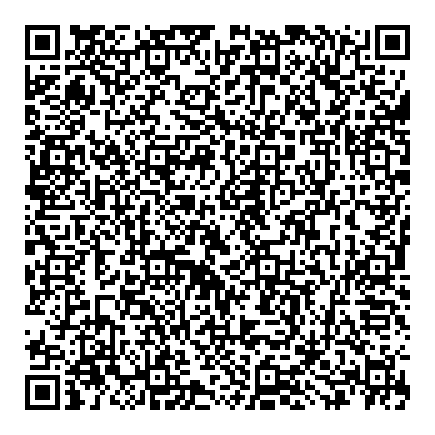

In [15]:
import qrcode

# Link for connection invitation
invitation_url = invitation_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(version=1, box_size=5, border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill="black", back_color="white")
img

## Accept Invitation Response

Note: You may not need to run this cell. It depends if this agent has the ACAPY_AUTO_ACCEPT_REQUESTS=true flag set.

In [ ]:
# Endpoint you expect to recieve messages at
my_endpoint = None
accept_request_response = await agent_controller.connections.accept_request(
    connection_id, my_endpoint
)

## Send Trust Ping

Once connection moves to response state one agent, either inviter or invitee needs to send a trust ping.

Note: you may not need to run this cell. It depends one of the agents has the ACAPY_AUTO_PING_CONNECTION=true flag set.

In [ ]:
comment = "Some Optional Comment"
message = await agent_controller.messaging.trust_ping(connection_id, comment)

## Optional: Recieve Proof Proposal

A Verifier is not the only role that can initiate the present-proof protocol. A holder can also send a proposal for a presentation that they can provide.

In [ ]:
# TODO...

## Send Proof Request

This identifies a connection and a proof request object (you will need to update the variable name enclosed with <>) 

In [ ]:
proof_request = {
    "comment": "<some optional comment>"
    "connection_id": connection_id,
    "proof_request": <some_proof_request_object>,
    # Do you want your agent to trace this request (for debugging)
    "trace": False
}

proof_request_response = await agent_controller.proofs.send_request(proof_request)

## Get Presentation Exchange Record

This record keeps track of the current state of the presentation protocol, which must be in the `presentation_received` state before the presentation can be verified.

Note: This could also happen in the webhook logic.

In [ ]:
presentation_exchange_id = proof_request_response["presentation_exchange_id"]

pres_record = await agent_controller.proofs.get_record_by_id(presentation_exchange_id)

print(pres_record)

## Verify Presentation

Only if it is in the right state. 

Note: Verifying a presentation moves the state to `verified` regardless of whether the presentation request has been satisfied. To check this you must refer to the `verified` property on the response.

In [ ]:
verified_response = await agent_controller.proofs.verify_presentation(
    presentation_exchange_id
)

verified = verified_response["verified"]

## Parsing Disclosed Attribute Values from Presentation

A presentation object contains three classes of attributes. 
* Revealed Attributes: Attributes that were signed by an issuer and have been revealed in the presentation process
* Self Attested Attributes: Attributes that the prover has self attested to in the presentation object.
* Predicate proofs: Attribute values that have been proven to meet some statement. (TODO: Show how you can parse this information)

### Parse Revealed Attributes

In [ ]:
for (name, val) in verified_response["presentation"]["requested_proof"][
    "revealed_attrs"
].items():
    ## This is the actual data that you want. It's a little hidden
    print("Attribute : ", val)
    print("Raw Value : ", val["raw"])

### Parse Self-Attested Attributes

In [ ]:
for (name, val) in verify["presentation"]["requested_proof"][
    "self_attested_attrs"
].items():
    print(name)
    ## Slightly different for self attested attrs
    print(val)

## Your Own Business Logic

Now you should have an established, active connection you can write any custom logic you want to engage with protocols with the connection

In [ ]:
## Custom Logic

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [16]:
await agent_controller.terminate()